In [1]:
import numpy
import powerbox
from matplotlib import pyplot
from scipy.constants import c
from numpy import pi as pi
from mpl_toolkits.axes_grid1 import make_axes_locatable


import sys
sys.path.append('../../../redundant_calibration/code/SCAR')
from RadioTelescope import antenna_gain_creator
from RadioTelescope import baseline_converter
from RadioTelescope import xyz_position_creator
from SkyModel import flux_list_to_sky_image
from SkyModel import flux_distribution
from quick_simulation_visibility_covariance import lm_to_theta_phi
from quick_simulation_visibility_covariance import mwa_tile_beam
from scipy.constants import c as light_speed

def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

In [2]:
def beam_width(frequency, diameter= 4, epsilon = 1):
    
    sigma =  epsilon*c/(frequency*diameter)
    width = numpy.sin(0.5*sigma)
    return width


def ideal_gaussian_beam(source_l, source_m, nu, diameter = 4, epsilon = 1):
    sigma = beam_width(nu, diameter, epsilon)
    
    beam_attenuation = numpy.exp(-(source_l**2. +  source_m**2.)/(2*sigma**2))
    
    return beam_attenuation


def broken_gaussian_beam(faulty_dipole, ideal_beam, source_l, source_m, nu, diameter = 4, epsilon = 1, dx=1.1):
    wavelength = c/nu    
    x_offsets = numpy.array([-1.5, -0.5, 0.5, 1.5, -1.5, -0.5, 0.5, 1.5, -1.5,
                             -0.5, 0.5, 1.5, -1.5, -0.5, 0.5, 1.5], dtype=numpy.float32)*dx

    y_offsets = numpy.array([1.5, 1.5, 1.5, 1.5, 0.5, 0.5, 0.5, 0.5, -0.5, -0.5,
                             -0.5, -0.5, -1.5, -1.5, -1.5, -1.5], dtype=numpy.float32)*dx
    
    dipole_beam = ideal_gaussian_beam(source_l, source_m, nu, diameter/4)
    broken_beam = ideal_beam - 1/16*dipole_beam*numpy.exp(-2.*numpy.pi*1j*(x_offsets[faulty_dipole]*numpy.abs(source_l)+ 
                                                                           y_offsets[faulty_dipole]*numpy.abs(source_m))/wavelength)
    
    return broken_beam


def ideal_mwa_beam_loader(theta, phi, frequency, load=True):
    if not load:
        if verbose:
            print("Creating the idealised MWA beam\n")
        ideal_beam = mwa_tile_beam(tt, pp, frequency=ff)
        if not os.path.exists("beam_maps"):
            print("")
            print("Creating beam map folder locally!")
            os.makedirs("beam_maps")
        numpy.save(f"beam_maps/ideal_beam_map.npy", ideal_beam)
    if load:
        if verbose:
            print("Loading the idealised MWA beam\n")
        ideal_beam = numpy.load(f"beam_maps/ideal_beam_map.npy")
    
    return ideal_beam


def broken_mwa_beam_loader(theta, phi, frequency, faulty_dipole, load =True):
    dipole_weights = numpy.zeros(16) + 1
    dipole_weights[faulty_dipole] = 0
    if load:
        print(f"Loading perturbed tile beam for dipole {faulty_dipole}")
        perturbed_beam = numpy.load(f"beam_maps/perturbed_dipole_{faulty_dipole}_map.npy")
    elif not load:
        #print(f"Generating perturbed tile beam for dipole {faulty_dipole}")
        perturbed_beam = mwa_tile_beam(tt, pp, weights=dipole_weights, frequency=ff)
        if not os.path.exists("beam_maps"):
            print("")
            print("Creating beam map folder locally!")
            os.makedirs("beam_maps")
        numpy.save(f"beam_maps/perturbed_dipole_{faulty_dipole}_map.npy", perturbed_beam)
    
    return perturbed_beam


def visibility_generator(sky_cube, antenna1_response, antenna2_response, pad_factor = 3):
    apparent_sky = sky_cube * antenna1_response * numpy.conj(antenna2_response)

    padded_sky = numpy.pad(apparent_sky, pad_factor * len(apparent_sky), mode="constant")
    shifted_image = numpy.fft.ifftshift(padded_sky, axes=(0, 1))
    visibility_grid, uv_coordinates = powerbox.dft.fft(shifted_image, L=2 * (2*pad_factor + 1), axes=(0, 1))
    
    return visibility_grid, uv_coordinates


def generate_visibility_realisations(max_x, max_y, frequency_range, sky_param, sky_seed = 0, 
                                     beam_type = "gaussian", load =True, verbose = False):
    xyz_positions = numpy.zeros((2,4))
    xyz_positions[0,1] = 0
    xyz_positions[0,2] = 0

    xyz_positions[1,1] = max_x
    xyz_positions[1,2] = max_y
    
    gain_table = antenna_gain_creator(xyz_positions, frequency_range)
    baseline_table = baseline_converter(xyz_positions, gain_table, frequency_range, verbose = verbose)
    
    if sky_param[0] == 'random':
        all_flux, all_l, all_m = flux_distribution(['random', sky_seed])
    elif sky_param[0] == 'point':
        all_flux, all_l, all_m = flux_distribution(['single', sky_param[1],
                                                    sky_param[2], sky_param[3]])
    point_source_list = numpy.stack((all_flux, all_l, all_m), axis=1)
    
    if verbose:
        print("Creating the sky\n")
    sky_cube, l_coordinates, m_coordinates = flux_list_to_sky_image(point_source_list, baseline_table)
    ll, mm, ff = numpy.meshgrid(l_coordinates, m_coordinates, frequency_range)
    
    if beam_type == "MWA":
        tt, pp, = lm_to_theta_phi(ll, mm)
        ideal_beam = ideal_mwa_beam_loader(tt,pp,ff, load)
    elif beam_type == "gaussian":
        ideal_beam = ideal_gaussian_beam(ll, mm, ff)
    padfactor = 3
    
    if verbose:
        print("Iterating over frequencies")
    
    uvf_variance = numpy.zeros((ll.shape[0]*(2*padfactor + 1), ll.shape[1]*(2*padfactor + 1), len(frequency_range)),
                               dtype=complex)
    for frequency_index in range(len(frequency_range)):
        visibility_realisations = numpy.zeros((ll.shape[0]*ll.shape[1]*(2*padfactor + 1)**2, 16), 
                                              dtype = complex)
        for faulty_dipole in range(16):
            if beam_type == "MWA":
                tt, pp, = lm_to_theta_phi(ll, mm)
                broken_beam = broken_mwa_beam_loader(tt, pp, ff, faulty_dipole, load)
            if beam_type == "gaussian":
                broken_beam = broken_gaussian_beam(faulty_dipole, ideal_beam, ll, mm, ff)
            
            visibilities, uv_grid = visibility_generator(sky_cube[...,frequency_index], ideal_beam[...,frequency_index], 
                                 broken_beam[...,frequency_index], pad_factor = padfactor)
            
            visibility_realisations[:, faulty_dipole] = visibilities.flatten()
        
        uvf_variance[...,frequency_index] = numpy.var(visibility_realisations, axis=1).reshape(uv_grid.shape[1],uv_grid.shape[1])
    return uvf_variance, uv_grid
    

### Set up parameters for a uniform baseline coverage

In [3]:
dx_max = 50
dy_max = 50

sky_param = ['random', 200, -0.10, 0.0]
frequency_range = numpy.linspace(140, 160, 10)*1e6
noise_param = [False, 20e3, 40e3, 120]
beam_param = ['gaussian', 0.25, 0.25]

In [4]:
uvf_variance, uv_grid = generate_visibility_realisations(dx_max, dy_max, frequency_range, sky_param, 
                                                         sky_seed = 0,  beam_type = "gaussian", load =True, 
                                                         verbose = True)


Converting xyz to uvw-coordinates

Number of antenna = 2
Total number of baselines = 1
Creating the sky

Iterating over frequencies


In [14]:
PS_2D, u_bins =  powerbox.tools.angular_average_nd(uvf_variance, [uv_grid[0], uv_grid[1], frequency_range], 
                                           bins = 500, n = 2)


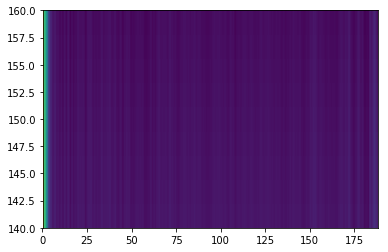

In [15]:
pyplot.pcolor(u_bins, frequency_range/1e6, numpy.log10(numpy.abs(PS_2D.T)))

In [19]:
print(uv_grid[0])

[-133.21428571 -133.14285714 -133.07142857 ...  133.07142857  133.14285714
  133.21428571]
